In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.integrate
import astropy.units as u
import pandas as pd

%matplotlib inline 

try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())



zmin = 0.0
zmax = 1.0
mmin = 3.e14 # Msun. 
mmax = 1.e15 # Msun



from astropy.io import fits
from astropy.table import Table


ncdata_fits = fits.open('skysim5000_halos_m200c_13.fits')
#ncdata_fits.info()

ncdata_data =  ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table
ncdata_Table['M200c'] = ncdata_Table['halo_mass']/0.71 # sod_halo_mass = M200,c in Msun/h, needs conversion

filt3 = ncdata_Table['M200c'] >= mmin
filt4 = ncdata_Table['M200c'] < mmax
filt5 = ncdata_Table['redshift_true'] >= zmin
filt6 = ncdata_Table['redshift_true'] < zmax

filt = filt3 * filt4 * filt5 * filt6

data_m_ss = ncdata_Table['M200c'][filt] # M200,c [Msun]
data_z_ss = ncdata_Table['redshift_true'][filt]
N_cl = len(data_m_ss)
print(f'There are {N_cl} halos in this mass (Msod) and redshift range')





cosmo = Nc.HICosmoDEXcdm()
reion = Nc.HIReionCamb.new () 
prim = Nc.HIPrimPowerLaw.new () 

cosmo.add_submodel (reion)
cosmo.add_submodel (prim)

dist = Nc.Distance.new (2.0)

tf = Nc.TransferFunc.new_from_name ("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new (tf)

#psml = Nc.PowspecMLCBE.new ()
psml.require_kmin (1.0e-6)
psml.require_kmax (1.0e3)

psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()

#
# New multiplicity function 'NcMultiplicityFuncTinkerMean'
#
#mulf = Nc.MultiplicityFuncTinker.new_full (Nc.MultiplicityFuncMassDef.CRITICAL,200)
mulf = Nc.MultiplicityFuncWatson.new ()
mulf.set_mdef (Nc.MultiplicityFuncMassDef.FOF)


#0 correspond to DM only and 1 to hydro sim
#mulf = Nc.MultiplicityFuncBocquet.new_full (Nc.MultiplicityFuncMassDef.CRITICAL,0,200)

#
# New mass function object using the objects defined above.
#
mf = Nc.HaloMassFunction.new (dist, psf, mulf)



There are 13363 halos in this mass (Msod) and redshift range


In [26]:
cosmo.props.H0      = 71
cosmo.props.Omegab  = 0.0448
cosmo.props.Omegac  = 0.265
cosmo.props.Omegax  = 0.7352

cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("Omegak", 0.0)

prim.props.n_SA = 0.963
print(0.8,cosmo.sigma8(psf),cosmo.Omega_k0())

old_amplitude = math.exp (prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log ((0.8 / cosmo.sigma8(psf))**2 * old_amplitude)
print(0.8, cosmo.sigma8(psf))

0.8 0.9600321906385438 0.0
0.8 0.8


In [27]:


#
# New Cluster Mass object
#
lnM_min = math.log (mmin)
lnM_max = math.log (mmax)

# using Log normal distribution
#cluster_m = Nc.ClusterMass.new_from_name ("NcClusterMassLnnormal{'lnMobs-min':<%20.15e>, 'lnMobs-max':<%20.15e>}" % (lnM_min, lnM_max))
#cluster_m.props.bias       = 0.0
#cluster_m.props.sigma      = 0.2
#print(cluster_m.lnMobs_min, cluster_m.lnMobs_max, lnM_min, lnM_max)

# no distribution - assumes masses are perfectly known
cluster_m = Nc.ClusterMass.new_from_name ("NcClusterMassNodist{'lnM-min':<%20.15e>, 'lnM-max':<%20.15e>}" % (lnM_min, lnM_max))
print(cluster_m.props.lnM_min, cluster_m.props.lnM_max, lnM_min, lnM_max)



33.33480359058475 34.53877639491068 33.33480359058475 34.538776394910684


In [28]:
#
# New Cluster Redshift object
#

# using a global gaussian distribution
#cluster_z = Nc.ClusterRedshift.new_from_name ("NcClusterPhotozGaussGlobal{'pz-min':<%20.15e>, 'pz-max':<%20.15e>, 'z-bias':<0.0>, 'sigma0':<0.03>}" % (zmin, zmax))

# no distribution - assumes redshifts are perfectly known
cluster_z = Nc.ClusterRedshiftNodist(z_min = zmin, z_max=zmax)
print(cluster_z.props.z_min, cluster_z.props.z_max, zmin, zmax)


0.0 1.0 0.0 1.0


In [29]:
#
# New Cluster abundance object that uses all objects above
#
cad = Nc.ClusterAbundance.new (mf, None)

#
# New NcmData object for number count calculations
#
ncdata = Nc.DataClusterNCount.new (cad, "NcClusterRedshiftNodist", "NcClusterMassNodist")

#
#  Creating a new Modelset and set cosmo as the HICosmo model to be used
#  and cluster_m as the distribution of the mass-observable relation
#
mset = Ncm.MSet.new_array ([cosmo, cluster_z, cluster_m])


In [30]:
#
# Fill ncdata with SkySim masses and redshifts
#

ncdata.set_lnM_true(Ncm.Vector.new_array(np.log (data_m_ss)))
ncdata.set_z_true(Ncm.Vector.new_array(data_z_ss))

# Because we are using true masses and redshifts in this example,
# we replicate the true data in the 'observed' masses and redshift attributes
ncdata.set_lnM_obs (Ncm.Matrix.new_array (data_m_ss,1))
ncdata.set_z_obs (Ncm.Matrix.new_array (data_z_ss,1))

#ncdata.props.area = skysim_cat.sky_area
mf.set_area_sd (5264.05)
ncdata.true_data (True)
ncdata.set_init(True)

In [31]:
cosmo.props.Omegac_fit    = True
cosmo.props.Omegab_fit    = False
prim.props.ln10e10ASA_fit = True

# data set
dset = Ncm.Dataset.new ()
dset.append_data (ncdata)


# New likelihood object using dset
lh = Ncm.Likelihood.new (dset)

In [32]:
#
#  Creating a Fit object of type NLOPT using the fitting algorithm ln-neldermead to
#  fit the Modelset mset using the Likelihood lh and using a numerical differentiation
#  algorithm (NUMDIFF_FORWARD) to obtain the gradient (if needed).
#
fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

fit.run_restart (Ncm.FitRunMsgs.SIMPLE,1e-3,0,None,None)

#
# Printing fitting informations.
#
fit.log_info ()
fit.obs_fisher ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:12.5361900
#  iteration            [000072]
#  function evaluations [000074]
#  gradient evaluations [000000]
#  degrees of freedom   [013361]
#  m2lnL     =    -6314.28750503507 (    -6314.2875 )
#  Fit parameters:
#     0.2254862904079      3.15359860806446    
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 962.958768237268      
#  - relative improvement: -0.179947600979097    
#  - m2lnL_0  :            -5351.3287367978      
#  - m2lnL_1  :            -6314.28750503507     
#-------------------------------------------------------------------

In [33]:
print (cosmo.props.Omegac,0.265)
print(0.8, cosmo.sigma8(psf))

0.2254698097227377 0.265
0.8 0.8525411675640137


In [34]:
#
# Setting single thread calculation.
#
Ncm.func_eval_set_max_threads (3)
Ncm.func_eval_log_pool_stats ()

#
# Additional functions as we want the chains for sigma8 and Omegam, which are derived parameters
#
mfunc_oa = Ncm.ObjArray.new ()

mfunc_sigma8 = Ncm.MSetFuncList.new ("NcHICosmo:sigma8", psf)
mfunc_Omegam = Ncm.MSetFuncList.new ("NcHICosmo:Omega_m0", None)

mfunc_oa.add (mfunc_sigma8)
mfunc_oa.add (mfunc_Omegam)

print (mfunc_sigma8.eval0 (mset))
print (mfunc_Omegam.eval0 (mset))

#
# New Gaussian prior to provide the initial points for the chain.
# It was created with size 0 (number of parameters), but once 
# initialized with mset the correct size is assigned. 
#
# The initial sampler will use a diagonal covariance with the
# diagonal terms being the parameters scale set by each model.
#
init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0) #1

#
# Creates the ESMCMC walker object, this object is responsible
# for moving the walkers in each interation, the stretch move
# is affine invariant and therefore gives good results even for
# very correlated parametric space.
# 
sampler = 'apes'
#sampler  = 'stretch'
nwalkers = int (math.ceil (500)) #500
ssize    = 15000 #1000000

if sampler == 'apes':
  walker = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
elif sampler == "stretch":
  walker = Ncm.FitESMCMCWalkerStretch.new (nwalkers, mset.fparams_len ())
#
# The methods below set the walk scale, which controls the size of the
# step done between two walkers and circumscribe the walkers inside
# the box defined by the parameters inside the mset object.
#
#walker.set_scale (3.0)
#walker.set_box_mset (mset)
#
# Initialize the ESMCMC object using the objects above. It will
# use 50 walkers, i.e., each point in the MCMC chain contains
# 50 points in the parametric space. Each step uses the last point
# in the chain (the last 50 parametric points) to calculate the
# proposal points.
#
esmcmc  = Ncm.FitESMCMC.new_funcs_array (fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa)

#
# These methods enable the auto-trim options on ESMCMC. This option 
# makes the sampler check the chains' health and trim any unnecessary 
# burn-in part. We set the number of divisions to 100 so we test the
# chains in blocks of n/100. The last method asserts that each 2min
# the catalog will be checked.
#
#esmcmc.set_auto_trim (True)
#esmcmc.set_auto_trim_div (100)
#esmcmc.set_max_runs_time (2.0 * 60.0)
#esmcmc.set_nthreads (4)
esmcmc.set_data_file ("Test_NC_%s_st_%d_true_watson_z_%f_%f.fits" % (sampler, nwalkers , zmin,zmax))
esmcmc.set_nthreads (3)

#
# Running the esmcmc, it will first calculate 1000 points, after that
# it will estimate the error in the parameters mean. Using the current
# errors the algorithm tries to calculated how many extra steps are 
# necessary to obtain the required error `10^-3' in every parameters,
# and it will run such extra steps. It will repeat this procedure
# until it attains the required error in every parameter.
# 
#

esmcmc.start_run ()
esmcmc.run (ssize / nwalkers)
#esmcmc.run (10)
#esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run ()

#
# Calculates the parameter means and covariance and set it into 
# the fit object and then print.
# 
esmcmc.mean_covar ()
# until it attains the required error in every parameter.
fit.log_covar ()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      3
0.8525411675640137
0.2702698097227377
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0003.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 3061755622.
# NcmMSetCatalog: Current mean:   45987        0.97517      0.26987      0.22507      3.2943     
# NcmMSetCatalog: Current msd:    2200.8       0.016378     0.0004384    0.0004384    0.032251   
# NcmMSetCatalog: Current sd:     49211        0.36623      0.0098029    0.0098029    0.72115    
# NcmMSetCatalog: Current var:    2.4218e+09   0.13413      9.6096e-05   9.6096e-05   0.52006    
# NcmMSetCatalog: Current tau:    1            1   

In [35]:
mcat = esmcmc.peek_catalog ()
print(0.265 +  0.0448, 0.8)
print(cosmo.props.Omegac + cosmo.props.Omegab, cosmo.sigma8(psf))

0.3098 0.8
0.2707895664418818 0.8571301783076823


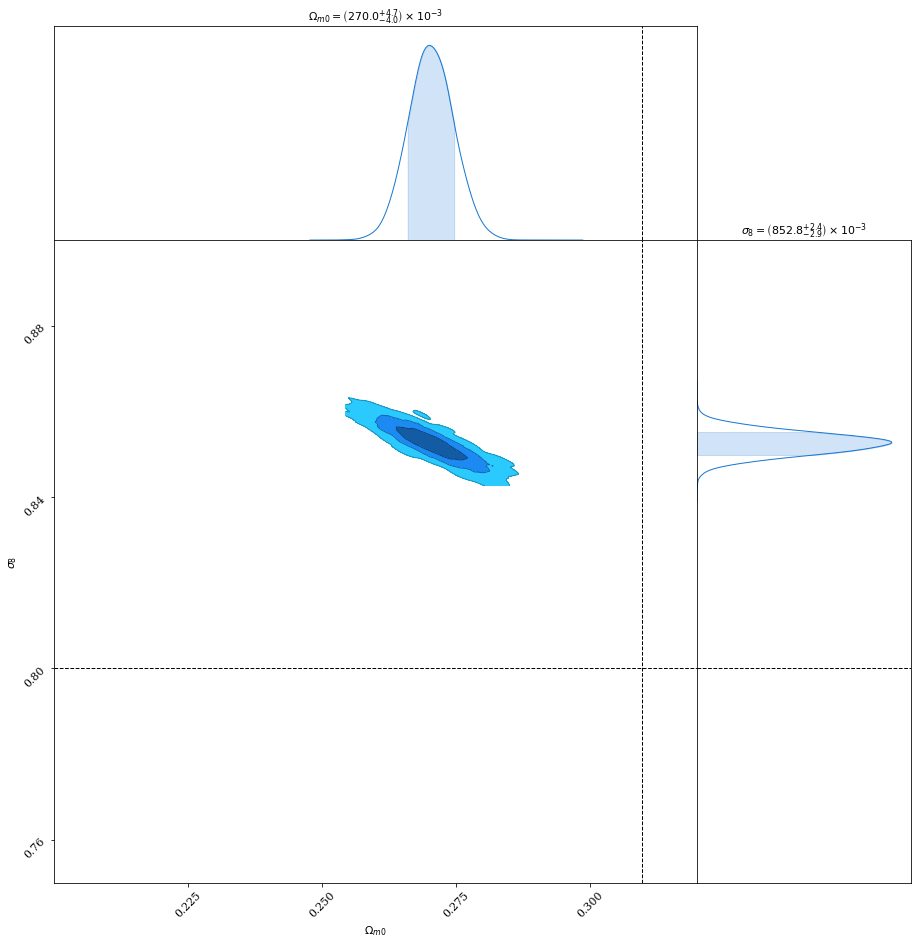

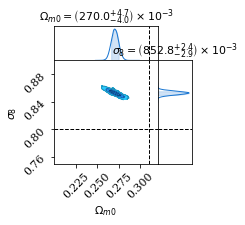

In [36]:


from chainconsumer import ChainConsumer

c = ChainConsumer()

nwalkers = mcat.nchains ()
m2lnL = mcat.get_m2lnp_var () 

rows = np.array ([mcat.peek_row (i).dup_array () for i in range (nwalkers * 10, mcat.len ())])
params = ["$" + mcat.col_symb (i) + "$" for i in range (mcat.ncols ())]
posterior = -0.5 * rows[:,m2lnL]

rows   = np.delete (rows,   m2lnL, 1)
params = np.delete (params, m2lnL, 0)

indices = [1,0]

rows   = rows[:,indices]
params = params[indices]

c.add_chain(rows, posterior = posterior, parameters=list(params))
c.configure (kde = True, label_font_size=11, sigma2d=False, sigmas = [1, 2,3], spacing = 0.0, tick_font_size=11, usetex=False)


plot_args = {}
plot_args['truth'] = [0.265 +  0.0448, 0.8]
plot_args['extents'] = [(0.2, 0.32),(0.75, 0.9)]

fig = c.plotter.plot(**plot_args)
c.plotter.plot(filename='z[0.0,1.0]_camb.png', figsize=0.75, **plot_args)
fig.set_size_inches(14.0, 14.0)

In [2]:
def add_mcat(c, mcat, name):
    nwalkers = mcat.nchains ()
    m2lnL = mcat.get_m2lnp_var ()

    # Use nwalkers * 10 as burning length
    burn = nwalkers * burnin
    rows = np.array ([mcat.peek_row (i).dup_array () for i in range (burn, mcat.len ())])
    params = ["$" + mcat.col_symb (i) + "$" for i in range (mcat.ncols ())]

    posterior = -0.5 * rows[:,m2lnL]

    rows   = np.delete (rows,   m2lnL, 1)
    params = np.delete (params, m2lnL, 0)

    indices = [0,1]

    rows   = rows[:,indices]
    params = params[indices]

    c.add_chain(rows, posterior = posterior, parameters=list(params), name=name)

[0.8, 0.3098]


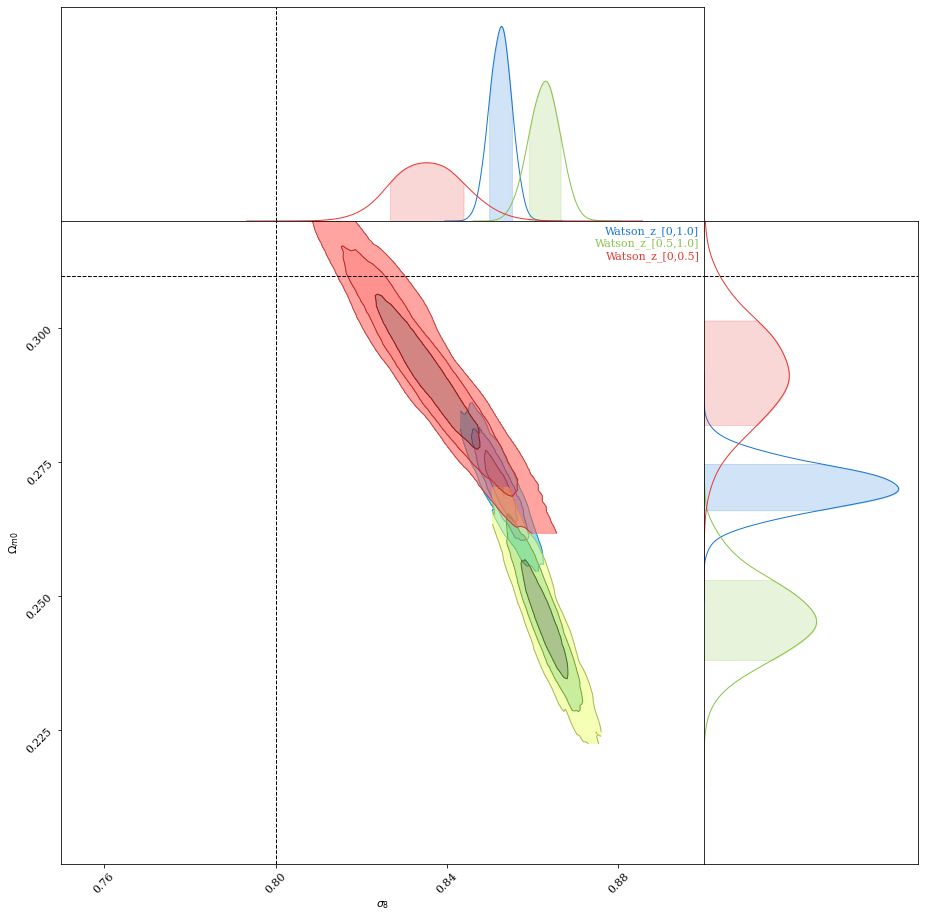

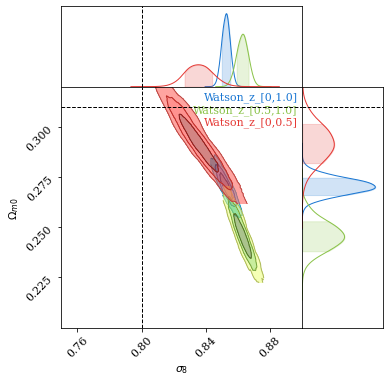

In [8]:
nwalkers = 50
burnin   = 10
mcat_Watson_1 = Ncm.MSetCatalog.new_from_file_ro ('Test_NC_apes_st_500_true_watson_z_0.000000_1.000000.fits', nwalkers * burnin)
mcat_Watson_2 = Ncm.MSetCatalog.new_from_file_ro ('Test_NC_apes_st_500_true_watson_z_0.500000_1.000000.fits', nwalkers * burnin)
mcat_Watson_3 = Ncm.MSetCatalog.new_from_file_ro ('Test_NC_apes_st_500_true_watson_z_0.000000_0.500000.fits', nwalkers * burnin)
from chainconsumer import ChainConsumer

c = ChainConsumer()

add_mcat(c, mcat_Watson_1, 'Watson_z_[0,1.0]')
add_mcat(c, mcat_Watson_2, 'Watson_z_[0.5,1.0]')
add_mcat(c, mcat_Watson_3, 'Watson_z_[0,0.5]')
c.configure (kde = True, label_font_size=11, sigma2d=False, sigmas = [1, 2,3], spacing = 0.0, tick_font_size=11, usetex=False)


plot_args = {}
plot_args['truth'] = [0.8,0.265 +  0.0448]
plot_args['extents'] = [(0.75, 0.9), (0.2, 0.32)]
print(plot_args['truth'])    
plot_name = 'watson_MCMC.png'
fig = c.plotter.plot(**plot_args)
c.plotter.plot(filename=plot_name, figsize=1.75, **plot_args)
fig.set_size_inches(14.0, 14.0)